# LinkedIn Jobs Analysis Project

## Introduction
This project focuses on analyzing LinkedIn job postings and related datasets to extract insights about job trends, required skills, company locations, and more. The primary goals are:
1. To explore and preprocess the data from LinkedIn job listings.
2. To identify trends and patterns in job types, skills, and company preferences.
3. To visualize and interpret results for actionable insights.

## Tools and Technologies
This project leverages Apache Spark for distributed data processing, Hadoop and Hive for efficient storage and querying, and Power BI for creating insightful visualizations and reports.



### Project Steps
- **Data Loading**: Import datasets from the HDFS directory.
- **Data Cleaning**: Handle missing or inconsistent values in the datasets.
- **Data Transformation**: Prepare the data for analysis by applying necessary transformations.
- **Analysis & Visualization**: Use exploratory data analysis (EDA) techniques to uncover trends.
- **Conclusion & Future Work**: Summarize findings and propose potential directions for future research.

---
    

## 1. Data Loading


In [64]:
#Importing necessary libraries
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from py4j.java_gateway import java_import
from pyspark.sql.functions import col, when, trim, split, explode, desc, isnan, count, to_date, regexp_extract, datediff
import matplotlib.pyplot as plt
import plotly.express as px
from geopy.geocoders import Nominatim
from wordcloud import WordCloud
import folium
from concurrent.futures import ThreadPoolExecutor

import seaborn as sns
import pandas as pd
from pyspark.sql.functions import array_contains,expr,lower
import ipywidgets as widgets
from IPython.display import display, HTML

In [65]:
# Step 1: Initializing Spark session with HDFS and Hive support, allocating 4GB memory for driver and executor.
spark = SparkSession.builder.appName("LinkedIn Job Analysis").config("spark.hadoop.fs.defaultFS", "hdfs://localhost:9000").config("spark.executor.memory", "4g").config("spark.driver.memory", "4g").enableHiveSupport().getOrCreate()

# Set Spark log level to display only errors.
spark.sparkContext.setLogLevel("ERROR")

# Print the Spark version to confirm successful initialization.
print(f"Spark version: {spark.version}")

Spark version: 3.5.3


In [66]:
# Step 2: Load datasets from HDFS with headers and schema inference enabled.
job_skills = spark.read.csv("hdfs://localhost:9000/user/nirvika/603Project/linkedin/job_skills.csv", header=True, inferSchema=True)
job_summary = spark.read.csv("hdfs://localhost:9000/user/nirvika/603Project/linkedin/job_summary.csv", header=True, inferSchema=True)
linkedin_job_listings = spark.read.csv("hdfs://localhost:9000/user/nirvika/603Project/linkedin/linkedin_job_postings.csv", header=True, inferSchema=True)

# Step 3: Display schema and sample rows for each dataset.
print("Job Skills Dataset Schema:")
job_skills.printSchema()
print("\nJob Summary Dataset Schema:")
job_summary.printSchema()
print("\nLinkedIn Job Listings Dataset Schema:")
linkedin_job_listings.printSchema()

print("\nJob Skills Dataset Sample:")
job_skills.show(5)
print("\nJob Summary Dataset Sample:")
job_summary.show(5)
print("\nLinkedIn Job Listings Dataset Sample:")
linkedin_job_listings.show(5)

Job Skills Dataset Schema:
root
 |-- job_link: string (nullable = true)
 |-- job_skills: string (nullable = true)


Job Summary Dataset Schema:
root
 |-- job_link: string (nullable = true)
 |-- job_summary: string (nullable = true)


LinkedIn Job Listings Dataset Schema:
root
 |-- job_link: string (nullable = true)
 |-- last_processed_time: string (nullable = true)
 |-- got_summary: string (nullable = true)
 |-- got_ner: string (nullable = true)
 |-- is_being_worked: string (nullable = true)
 |-- job_title: string (nullable = true)
 |-- company: string (nullable = true)
 |-- job_location: string (nullable = true)
 |-- first_seen: string (nullable = true)
 |-- search_city: string (nullable = true)
 |-- search_country: string (nullable = true)
 |-- search_position: string (nullable = true)
 |-- job_level: string (nullable = true)
 |-- job_type: string (nullable = true)


Job Skills Dataset Sample:
+--------------------+--------------------+
|            job_link|          job_skills|
+--

## 2. Data Cleaning

In [67]:
# Function to check null values in a dataset, excluding specified columns, and display the counts.
def check_null_values(df, dataset_name, exclude_columns=None):
    
    if exclude_columns is None:
        exclude_columns = []

    # Exclude specific columns from null-check analysis.
    columns_to_check = [c for c in df.columns if c not in exclude_columns]
    
    # Count null and NaN values in the selected columns.
    null_counts = df.select(
        [count(when(col(c).isNull() | isnan(c), c)).alias(c) for c in columns_to_check]
    )
    
    # Convert null counts to a Pandas DataFrame for easy readability and display the results.
    print(f"Null Values in {dataset_name}:\n")
    null_counts_pd = null_counts.toPandas().T  # Transpose for better formatting.
    null_counts_pd.columns = ["Null Count"]
    print(null_counts_pd)

In [68]:
# Check for null values in each dataset and display results.
check_null_values(linkedin_job_listings, "Jobs Dataset")
check_null_values(job_summary, "Summary Dataset")
check_null_values(job_skills, "Job-Skills Dataset")


Null Values in Jobs Dataset:



                     Null Count
job_link                      0
last_processed_time           0
got_summary                   0
got_ner                       0
is_being_worked               0
job_title                     0
company                      45
job_location                 53
first_seen                   34
search_city                  68
search_country               68
search_position              68
job_level                    68
job_type                     69
Null Values in Summary Dataset:



             Null Count
job_link          68623
job_summary    32646898
Null Values in Job-Skills Dataset:



            Null Count
job_link             0
job_skills        2007


In [69]:
# Function to handle missing values by replacing null or missing entries with "Unknown".
def handle_missing_values(df, columns_to_check):
    for column in columns_to_check:
        df = df.withColumn(column, when(col(column).isNotNull(), col(column)).otherwise("Unknown"))
    return df

# Function to remove duplicate rows from the dataset.
def remove_duplicates(df):
    return df.dropDuplicates()

# Function to standardize column names:
# - Trims whitespace around column names.
# - Converts column names to lowercase for consistency.
def standardize_columns(df):
    standardized_columns = [trim(col(c)).alias(c.strip().lower()) for c in df.columns]
    return df.select(*standardized_columns)

# General function to clean a dataset:
# - Handles missing values, removes duplicates, and standardizes column names.
def clean_dataset(df, columns_to_check):
    cleaned_df = handle_missing_values(df, columns_to_check)
    cleaned_df = remove_duplicates(cleaned_df)
    cleaned_df = standardize_columns(cleaned_df)
    return cleaned_df

# Clean the datasets using the `clean_dataset` function and store the results.
job_skills_cleaned = clean_dataset(job_skills, job_skills.columns)
job_summary_cleaned = clean_dataset(job_summary, job_summary.columns)
linkedin_job_listings_cleaned = clean_dataset(linkedin_job_listings, linkedin_job_listings.columns)

# Display cleaned datasets (first 5 rows of each) for verification.
print("Job Skills Dataset (Cleaned):")
job_skills_cleaned.show(5)

print("Job Summary Dataset (Cleaned):")
job_summary_cleaned.show(5)

print("LinkedIn Job Listings Dataset (Cleaned):")
linkedin_job_listings_cleaned.show(5)


Job Skills Dataset (Cleaned):


+--------------------+--------------------+
|            job_link|          job_skills|
+--------------------+--------------------+
|https://www.linke...|Server Management...|
|https://www.linke...|Healthcare, Sales...|
|https://www.linke...|Psychiatric Techn...|
|https://www.linke...|HVAC, Sheet Metal...|
|https://www.linke...|Customer service,...|
+--------------------+--------------------+
only showing top 5 rows

Job Summary Dataset (Cleaned):


+--------------------+--------------------+
|            job_link|         job_summary|
+--------------------+--------------------+
|            About Us|             Unknown|
|Complete the dail...|             Unknown|
|We work hard to c...|and most importantly|
|Physical Demands:...|         stand; talk|
|Food Handler’s ce...|             Unknown|
+--------------------+--------------------+
only showing top 5 rows

LinkedIn Job Listings Dataset (Cleaned):


+--------------------+--------------------+-----------+-------+---------------+--------------------+--------------------+--------------------+----------+--------------+--------------+--------------------+----------+--------+
|            job_link| last_processed_time|got_summary|got_ner|is_being_worked|           job_title|             company|        job_location|first_seen|   search_city|search_country|     search_position| job_level|job_type|
+--------------------+--------------------+-----------+-------+---------------+--------------------+--------------------+--------------------+----------+--------------+--------------+--------------------+----------+--------+
|https://www.linke...|2024-01-21 07:12:...|          t|      t|              f|Sr Experience Des...|               Adobe|        New York, NY|2024-01-15|       Bayonne| United States|Cost-And-Sales-Re...|Mid senior|  Onsite|
|https://www.linke...|2024-01-19 14:39:...|          t|      t|              f|Superintendent, P...|

## 3. Data Transformation

In [70]:
# Import Java classes required for HDFS operations
# These classes will help interact with the Hadoop Distributed File System (HDFS)java_import(spark._jvm, 'org.apache.hadoop.fs.FileSystem')
java_import(spark._jvm, 'org.apache.hadoop.fs.FileSystem')
java_import(spark._jvm, 'org.apache.hadoop.fs.Path')

# Obtain an instance of the HDFS FileSystem using the Hadoop configuration
hdfs = spark._jvm.FileSystem.get(spark._jsc.hadoopConfiguration())

# Define the path for the output file in HDFS where the merged dataset will be saved
output_path = "hdfs://localhost:9000/user/nirvika/603Project/linkedin/merged_linkedin_data.csv"

# Create a Path object to represent the output path
path = spark._jvm.Path(output_path)
if not hdfs.exists(path):
    # Merge Datasets on 'job_link' (inner join to ensure all data is consistent across datasets)
    merged_data = job_skills_cleaned.join(job_summary_cleaned, on='job_link', how='inner')
    merged_data = merged_data.join(linkedin_job_listings_cleaned, on='job_link', how='inner')

    # Save Merged Dataset
    # Use 'coalesce(1)' to combine all partitions into one, creating a single output file.
    # The 'mode="overwrite"' option will overwrite any existing file at the output path.    
    merged_data.coalesce(1).write.csv(output_path, header=True, mode="overwrite")
    print("Merged dataset has been saved.")
else:
    print(f"Merged dataset already exists at {output_path}. Fetching data..")
    merged_data = spark.read.csv("hdfs://localhost:9000/user/nirvika/603Project/linkedin/merged_linkedin_data.csv", header=True, inferSchema=True)


Merged dataset already exists at hdfs://localhost:9000/user/nirvika/603Project/linkedin/merged_linkedin_data.csv. Fetching data..


In [71]:
# Display the schema of the merged dataset to show the structure and data types of each column
print("Merged Dataset Schema:")
merged_data.printSchema()

print("\nMerged Dataset Sample:")
merged_data.show(5)

# Check the number of rows and columns
num_rows = merged_data.count()
num_columns = len(merged_data.columns)
print(f"Merged Dataset: {num_rows} rows, {num_columns} columns")


Merged Dataset Schema:
root
 |-- job_link: string (nullable = true)
 |-- job_skills: string (nullable = true)
 |-- job_summary: string (nullable = true)
 |-- last_processed_time: timestamp (nullable = true)
 |-- got_summary: string (nullable = true)
 |-- got_ner: string (nullable = true)
 |-- is_being_worked: string (nullable = true)
 |-- job_title: string (nullable = true)
 |-- company: string (nullable = true)
 |-- job_location: string (nullable = true)
 |-- first_seen: string (nullable = true)
 |-- search_city: string (nullable = true)
 |-- search_country: string (nullable = true)
 |-- search_position: string (nullable = true)
 |-- job_level: string (nullable = true)
 |-- job_type: string (nullable = true)


Merged Dataset Sample:
+--------------------+--------------------+--------------------+--------------------+-----------+-------+---------------+--------------------+--------------------+--------------------+----------+---------------+--------------+--------------------+---------

Merged Dataset: 1296381 rows, 16 columns


In [72]:
# Iterate over each column in the merged dataset to count the number of distinct values
for column in merged_data.columns:
    distinct_count = merged_data.select(column).distinct().count()
    print(f"Distinct count in column '{column}': {distinct_count}")

Distinct count in column 'job_link': 1296381


Distinct count in column 'job_skills': 1287098


Distinct count in column 'job_summary': 375082


Distinct count in column 'last_processed_time': 722728


Distinct count in column 'got_summary': 1


Distinct count in column 'got_ner': 1


Distinct count in column 'is_being_worked': 1


Distinct count in column 'job_title': 565681


Distinct count in column 'company': 89012


Distinct count in column 'job_location': 28808


Distinct count in column 'first_seen': 34


Distinct count in column 'search_city': 1027


Distinct count in column 'search_country': 25


Distinct count in column 'search_position': 1928


Distinct count in column 'job_level': 22


Distinct count in column 'job_type': 8


In [73]:
# Select the 'job_type' column from the merged dataset and retrieve the distinct values
merged_data.select('job_type').distinct().show()

+--------------------+
|            job_type|
+--------------------+
|              Remote|
|Radiation-Therapy...|
|              Onsite|
|           Associate|
|             Unknown|
|              Hybrid|
|          Mid senior|
|              Driver|
+--------------------+



In [74]:
# Define a list of valid job types to keep in the dataset
valid_job_types = ['Remote', 'Onsite', 'Hybrid']

# Filter rows where 'job_type' is not in the valid job types
invalid_job_types_count = merged_data.filter(~col("job_type").isin(valid_job_types)).count()

# Print the count of rows with invalid job types
print(f"Count of rows with invalid job types: {invalid_job_types_count}")

merged_data = merged_data.filter(col("job_type").isin(valid_job_types))
print(f"Job Type cleaning completed. {invalid_job_types_count} rows with invalid job types were removed.")


Count of rows with invalid job types: 59
Job Type cleaning completed. 59 rows with invalid job types were removed.


In [75]:
for column in merged_data.columns:
    distinct_count = merged_data.select(column).distinct().count()
    print(f"Distinct count in column '{column}': {distinct_count}")

Distinct count in column 'job_link': 1296322


Distinct count in column 'job_skills': 1287039


Distinct count in column 'job_summary': 375066


Distinct count in column 'last_processed_time': 722701


Distinct count in column 'got_summary': 1


Distinct count in column 'got_ner': 1


Distinct count in column 'is_being_worked': 1


Distinct count in column 'job_title': 565651


Distinct count in column 'company': 88993


Distinct count in column 'job_location': 28792


Distinct count in column 'first_seen': 6


Distinct count in column 'search_city': 1018


Distinct count in column 'search_country': 4


Distinct count in column 'search_position': 1923


Distinct count in column 'job_level': 2


Distinct count in column 'job_type': 3


In [76]:
# Save the DataFrame to a Hive table, specifying 'overwrite' mode to replace any existing table with the same name
# Spark will automatically create the table schema and populate it with the data from 'merged_data'
merged_data.write.mode("overwrite").saveAsTable("linkedIn_job_postings_2024")

# Use Spark SQL to check the content of the newly created Hive table
# The query retrieves all the data from the 'linkedIn_job_postings_2024' table and displays the first 5 rows for review
spark.sql("SELECT * FROM linkedIn_job_postings_2024").show(5)


+--------------------+--------------------+--------------------+--------------------+-----------+-------+---------------+--------------------+--------------------+--------------------+----------+---------------+--------------+--------------------+----------+--------+
|            job_link|          job_skills|         job_summary| last_processed_time|got_summary|got_ner|is_being_worked|           job_title|             company|        job_location|first_seen|    search_city|search_country|     search_position| job_level|job_type|
+--------------------+--------------------+--------------------+--------------------+-----------+-------+---------------+--------------------+--------------------+--------------------+----------+---------------+--------------+--------------------+----------+--------+
|https://ae.linked...|EVS, EVS Operator...|    Responsibilities|2024-01-21 02:21:...|          t|      t|              f|        EVS Operator|              Sundus|Abu Dhabi, Abu Dh...|2024-01-17| 

## 4. Analysis & Visualization

+----------------------+-----+
|company               |count|
+----------------------+-----+
|Health eCareers       |40048|
|Jobs for Humanity     |25629|
|TravelNurseSource     |15997|
|Dollar General        |14775|
|PracticeLink          |9043 |
|Energy Jobline        |8987 |
|Gotham Enterprises Ltd|8700 |
|Jobot                 |8264 |
|ClearanceJobs         |8015 |
|McDonald's            |7742 |
+----------------------+-----+



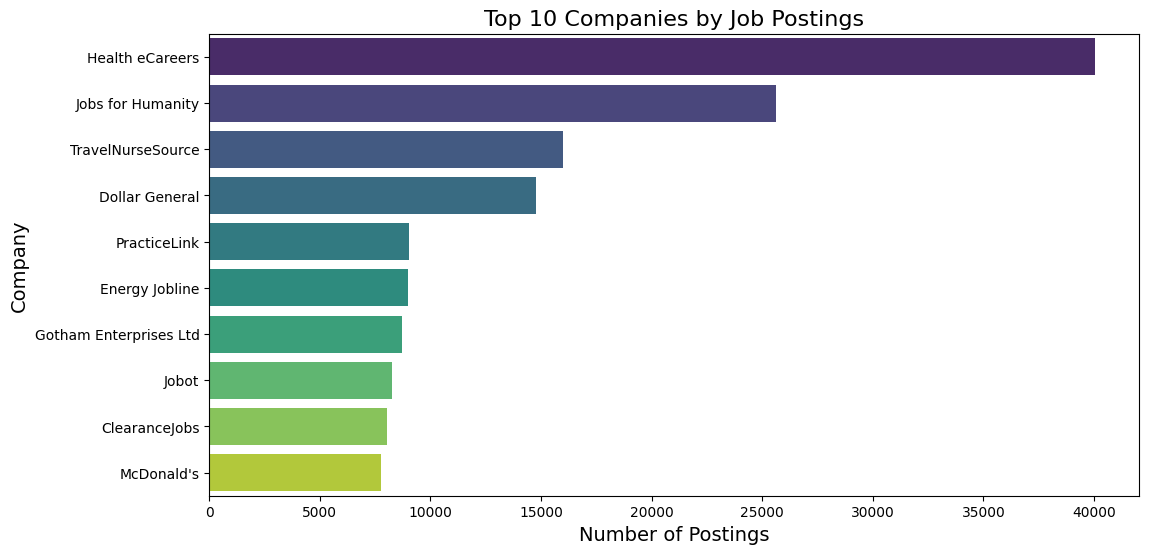

+---------------------+------+
|skill                |count |
+---------------------+------+
| Communication       |356344|
| Teamwork            |222992|
| Leadership          |162919|
| Communication skills|104691|
| Customer service    |104101|
| Problem Solving     |101726|
| Customer Service    |93458 |
| Problemsolving      |92203 |
| Collaboration       |86617 |
| Training            |82864 |
+---------------------+------+



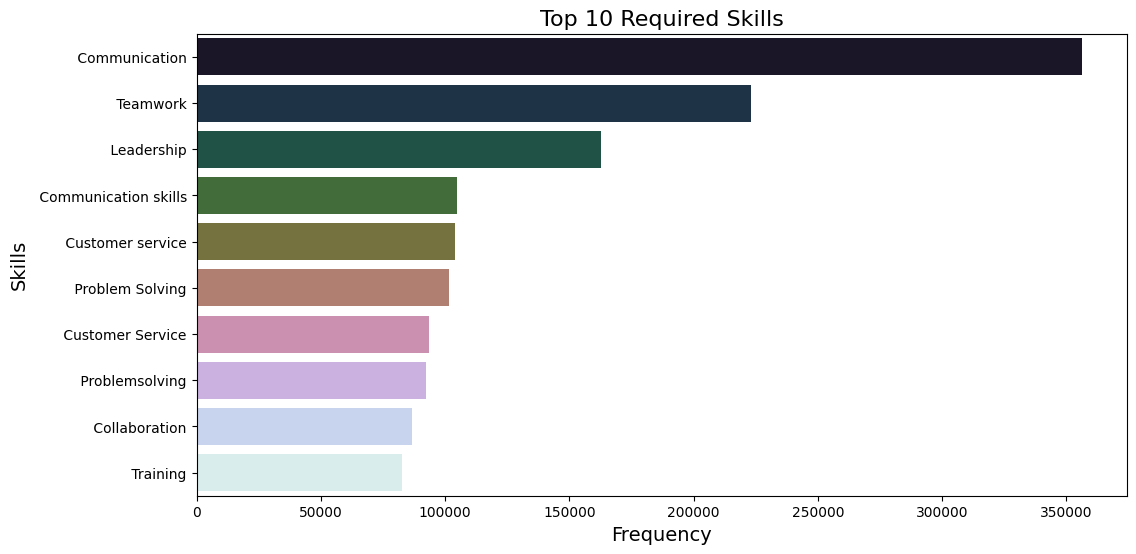

In [77]:
# Fetch the top 10 companies with the highest number of job postings from the Hive table and display them
top_companies_spark = spark.sql("""
    SELECT company, COUNT(*) AS count
    FROM linkedIn_job_postings_2024
    GROUP BY company
    ORDER BY count DESC
    LIMIT 10
""")

top_companies_spark.show(truncate=False) 
top_companies = top_companies_spark.toPandas()

# Plotting Top 10 Companies by Job Postings
plt.figure(figsize=(12, 6))
sns.barplot(x="count", y="company", data=top_companies, palette="viridis")
plt.title("Top 10 Companies by Job Postings", fontsize=16)
plt.xlabel("Number of Postings", fontsize=14)
plt.ylabel("Company", fontsize=14)
plt.show()

# Fetch the top 10 most required skills from job postings by splitting and counting skills
top_skills_Spark = spark.sql("""
    SELECT skill, COUNT(*) AS count
    FROM (
        SELECT explode(split(job_skills, ',')) AS skill
        FROM linkedIn_job_postings_2024
    ) skills
    GROUP BY skill
    ORDER BY count DESC
    LIMIT 10
""")

top_skills_Spark.show(truncate=False) 
top_skills = top_skills_Spark.toPandas()

# Plotting Top 10 Required Skills
plt.figure(figsize=(12, 6))
sns.barplot(x="count", y="skill", data=top_skills, palette="cubehelix")
plt.title("Top 10 Required Skills", fontsize=16)
plt.xlabel("Frequency", fontsize=14)
plt.ylabel("Skills", fontsize=14)
plt.show()


In [78]:
# Count and plot the top 20 job locations by the number of job postings from the Hive table.
location_counts_spark = spark.sql("""
    SELECT job_location, COUNT(*) AS count
    FROM linkedIn_job_postings_2024
    GROUP BY job_location
    ORDER BY count DESC
    LIMIT 20
""")
location_counts_df = location_counts_spark.toPandas()

fig = px.bar(location_counts_df, x="job_location", y="count", title="Top 20 Locations by Job Postings", labels={"job_location": "Location", "count": "Number of Jobs"})
fig.update_layout(xaxis_title="Location", yaxis_title="Number of Jobs")
fig.show()


In [79]:
# Fetch and plot the top 50 skills across different companies with their frequency in job postings.
skills_by_industry_hive = spark.sql("""
    SELECT company, skill, COUNT(*) AS skill_count
    FROM (
        SELECT company, explode(split(job_skills, ',')) AS skill
        FROM linkedIn_job_postings_2024
    ) exploded_skills
    WHERE company IS NOT NULL
    GROUP BY company, skill
    ORDER BY skill_count DESC
    LIMIT 50
""")

skills_by_industry_hive.show()

# Create a bubble plot using Plotly to visualize the top skills across industries, with skill frequency represented by bubble size.
fig = px.scatter(
    skills_by_industry_hive,
    x="company",
    y="skill",
    size="skill_count",
    color="company",
    title="Top Skills Across Industries (Bubble Plot)",
    labels={"company": "Company", "skill": "Skill", "skill_count": "Frequency"},
    size_max=60,
)
fig.update_layout(
    title_font_size=22,
    xaxis_title="Company",
    yaxis_title="Skill",
    legend_title="Company",
)
fig.show()


+-----------------+--------------------+-----------+
|          company|               skill|skill_count|
+-----------------+--------------------+-----------+
|  Health eCareers|             Nursing|      14758|
|  Health eCareers|       Communication|      10722|
|   Dollar General| Supervisory expe...|       9905|
|  Health eCareers|        Patient Care|       9421|
|   Dollar General| Mathematical cal...|       8711|
|   Dollar General| High school diploma|       8491|
|   Dollar General|       Cash handling|       7301|
|  Health eCareers|            Teamwork|       6923|
|Jobs for Humanity|       Communication|       6889|
|   Dollar General|    Customer service|       6328|
|       McDonald's|            Training|       6307|
|       McDonald's|          Scheduling|       6052|
|  Health eCareers|        Patient care|       6022|
|  Health eCareers|          Leadership|       5816|
|   Dollar General|    Customer service|       5674|
|Jobs for Humanity|            Teamwork|      

# Building Advanced Insights

In [80]:
# Function to create or retrieve a table in Hive based on whether it already exists.
def createTable(output_table, df):
    # Check if the table exists in Hive
    if not spark.catalog.tableExists(output_table):
        # Save the DataFrame to Hive
        df.write.mode("overwrite").saveAsTable(output_table)
        return "Dataset saved to Hive table: " + output_table
    else:
        # If the table exists, retrieve the data from Hive
        retrieved_data = spark.sql(f"SELECT * FROM {output_table}")
        print(f"Dataset already exists in Hive table: {output_table}. Retrieved successfully.")
        retrieved_data.distinct().show(20)
        return retrieved_data 

In [118]:
# Extract top 5 industries from the merged data
industry_counts = merged_data.groupBy("company").count().orderBy(desc("count"))
top_industries_df = industry_counts.limit(5)

# Collect top industries into a simple list
top_industries = [row["company"] for row in top_industries_df.collect()]
print("Top Industries:", top_industries)

Top Industries: ['Health eCareers', 'Jobs for Humanity', 'TravelNurseSource', 'Dollar General', 'PracticeLink']


In [123]:
from pyspark.sql.functions import explode, split

# Analyze skill gaps in top industries
skill_gap_analysis = merged_data.select("company", explode(split(col("job_skills"), ",")).alias("skill")) \
    .filter(col("company").isin(top_industries)) \
    .groupBy("company", "skill") \
    .count() \
    .orderBy(desc("count"))

print("Skill Gap Analysis:")
skill_gap_analysis.show(n=20, truncate=False)



Skill Gap Analysis:


+-----------------+--------------------------+-----+
|company          |skill                     |count|
+-----------------+--------------------------+-----+
|Health eCareers  |Nursing                   |14758|
|Health eCareers  | Communication            |10722|
|Dollar General   | Supervisory experience   |9905 |
|Health eCareers  | Patient Care             |9421 |
|Dollar General   | Mathematical calculations|8711 |
|Dollar General   | High school diploma      |8491 |
|Dollar General   | Cash handling            |7301 |
|Health eCareers  | Teamwork                 |6923 |
|Jobs for Humanity| Communication            |6889 |
|Dollar General   |Customer service          |6328 |
|Health eCareers  | Patient care             |6022 |
|Health eCareers  | Leadership               |5816 |
|Dollar General   | Customer service         |5674 |
|Jobs for Humanity| Teamwork                 |5565 |
|Dollar General   | Planogram implementation |5456 |
|Dollar General   | Driving                  |

In [81]:
# Analyze most frequently associated skills with top job titles
top_job_titles = merged_data.groupBy("job_title").count().orderBy(desc("count")).limit(5)

# Convert top job titles to a simple list
top_job_titles_list = [row["job_title"] for row in top_job_titles.collect()]


skills_job_titles = spark.sql("""
    SELECT job_title, skill, COUNT(*) AS skill_count
    FROM (
        SELECT job_title, explode(split(job_skills, ',')) AS skill
        FROM linkedIn_job_postings_2024
        WHERE job_title IN ({})
    ) exploded_skills
    GROUP BY job_title, skill
    ORDER BY job_title, skill_count DESC
""".format(",".join([f"'{title}'" for title in top_job_titles_list])))

output_table = "linkedin_skills_job_titles_analysis" 
df = skills_job_titles  

createTable(output_table, skills_job_titles)


Dataset already exists in Hive table: linkedin_skills_job_titles_analysis. Retrieved successfully.
+-----------------+--------------------+-----+
|        job_title|               skill|count|
+-----------------+--------------------+-----+
|Assistant Manager| Ability to work ...|   47|
|Assistant Manager| Basic personal c...|   26|
|Assistant Manager| Proven competent...|   22|
|Assistant Manager|  Health Regulations|   12|
|Assistant Manager| Cleanliness stan...|   10|
|Assistant Manager| Commercial aware...|    8|
|Assistant Manager| Decision making ...|    8|
|Assistant Manager|  Associate's degree|    7|
|Assistant Manager| Ability to reach...|    6|
|Assistant Manager|            reaching|    5|
|Assistant Manager| Basic Computer L...|    5|
|Assistant Manager|        Salesmanship|    5|
|Assistant Manager|   Hiring and Firing|    4|
|Assistant Manager|      Staff Discount|    4|
|Assistant Manager| Apprenticeship P...|    4|
|Assistant Manager|      Financial data|    4|
|Assista

DataFrame[job_title: string, skill: string, count: bigint]

In [82]:
# Define the SQL query for analyzing the most frequently associated skills in high-paying jobs
high_paying_skills = """SELECT skill, COUNT(*) AS skill_count
    FROM (
        SELECT EXPLODE(SPLIT(job_skills, ',')) AS skill
        FROM linkedIn_job_postings_2024
        WHERE job_summary RLIKE '(?i)high-paying|salary'
    ) exploded_skills
    GROUP BY skill
    ORDER BY skill_count DESC"""

output_table = "high_paying_job" 
df = high_paying_skills  

createTable(output_table, df)

Dataset already exists in Hive table: high_paying_job. Retrieved successfully.
+--------------------+-----+
|               skill|count|
+--------------------+-----+
| Communication sk...| 1313|
|         Food Safety|  197|
|               Drive|   37|
|                  C#|   33|
|         401(k) plan|   33|
|                Epic|   30|
|                  HR|   28|
| Basic Life Suppo...|   27|
| Previous UK nurs...|   25|
|            Sick Pay|   22|
|        Immunization|   21|
|    Sales management|   19|
| Mobile Carrier D...|   18|
|   Prescription Plan|   17|
|    Client education|   17|
|     Site Excavation|   17|
|             Quoting|   16|
| Restaurant manag...|   15|
| Weekend Availabi...|   15|
| Strong Communica...|   15|
+--------------------+-----+
only showing top 20 rows



DataFrame[skill: string, count: bigint]

In [83]:
# Define the SQL query for analyzing the most in-demand skills by location
skills_location_query = """
SELECT job_location, skill, COUNT(*) AS skill_count
FROM (
    SELECT job_location, EXPLODE(SPLIT(job_skills, ',')) AS skill
    FROM linkedIn_job_postings_2024
) exploded_skills
GROUP BY job_location, skill
ORDER BY job_location, skill_count DESC
"""

# Execute the SQL query and create a DataFrame
skills_location_df = spark.sql(skills_location_query)
output_table = "skills_location_table" 

# Use the createTable function to either save or retrieve the table in Hive
createTable(output_table, skills_location_df)


Dataset already exists in Hive table: skills_location_table. Retrieved successfully.


+------------+--------------------+-----+
|job_location|               skill|count|
+------------+--------------------+-----+
|New York, NY|      basic research|    1|
|New York, NY| Health and Safet...|    1|
|New York, NY|     Workshop safety|    1|
|New York, NY| Technical Develo...|    1|
|New York, NY| Women Owned and ...|    1|
|New York, NY|            requests|    1|
|New York, NY| Participant Brow...|    1|
|New York, NY| Portfolio manage...|    1|
|New York, NY| Direct Digital C...|    1|
|New York, NY| Feedback capabil...|    1|
|New York, NY| High energy envi...|    1|
|New York, NY|    Space Operations|    1|
|New York, NY| ZeroEmission Tec...|    1|
|New York, NY| Medical/Prescrip...|    1|
|New York, NY| Maintaining Indu...|    1|
|New York, NY|    Women's wellness|    1|
|New York, NY|FAR/CAS/OMB Circu...|    1|
|New York, NY| Asset Management...|    1|
|New York, NY|   GTM and EPD teams|    1|
|New York, NY|    Yield Operations|    1|
+------------+--------------------

DataFrame[job_location: string, skill: string, count: bigint]

In [84]:
# Define the SQL query for analyzing skill occurrences grouped by job level
skills_job_level_query = """
SELECT job_level, skill, COUNT(*) AS skill_count
FROM (
    SELECT job_level, EXPLODE(SPLIT(job_skills, ',')) AS skill
    FROM linkedIn_job_postings_2024
) exploded_skills
GROUP BY job_level, skill
ORDER BY job_level, skill_count DESC
"""

# Execute the SQL query and create a DataFrame
skills_job_level_df = spark.sql(skills_job_level_query)

# Specify the output table name
output_table = "skills_job_level_analysis"

# Use the createTable function to either save or retrieve the table in Hive
createTable(output_table, skills_job_level_df)

Dataset already exists in Hive table: skills_job_level_analysis. Retrieved successfully.


+----------+--------------------+-----------+
| job_level|               skill|skill_count|
+----------+--------------------+-----------+
|Mid senior| 4 years+ progres...|          1|
|Mid senior| Design for rehab...|          1|
|Mid senior| Licensing and re...|          1|
|Mid senior| Implementation a...|          1|
|Mid senior| Normal correctab...|          1|
|Mid senior|   Respect and trust|          1|
|Mid senior|   Cordless Trimmers|          1|
|Mid senior| Communications a...|          1|
|Mid senior|        Watchlisting|          1|
|Mid senior|        Menu Options|          1|
|Mid senior| Ability to use a...|          1|
|Mid senior| MS SQL Integrati...|          1|
|Mid senior| Automated Contro...|          1|
|Mid senior| Joint Mission En...|          1|
|Mid senior| Ability to commi...|          1|
|Mid senior|    Trade literature|          1|
|Mid senior| Experience with ...|          1|
|Mid senior| Unit Efficiency ...|          1|
|Mid senior|     E&SPC Plan Sets| 

DataFrame[job_level: string, skill: string, skill_count: bigint]

In [85]:
# Convert 'first_seen' to date format and analyze trends
time_trends = merged_data.withColumn("post_date", to_date(col("first_seen"), "yyyy-MM-dd")) \
    .groupBy("post_date") \
    .agg(count("job_link").alias("postings")) \
    .orderBy("post_date")


output_table = "time_trends_analysis" 
df = time_trends  

createTable(output_table, df)


Dataset already exists in Hive table: time_trends_analysis. Retrieved successfully.
+----------+--------+
| post_date|postings|
+----------+--------+
|2024-01-16|  123831|
|2024-01-15|   79395|
|2024-01-13|  403929|
|2024-01-17|   23731|
|2024-01-12|  206094|
|2024-01-14|  459342|
+----------+--------+



DataFrame[post_date: date, postings: bigint]

In [86]:
unwanted_headers = ["Job Description", "Responsibilities", "Qualifications", "Skills", "Requirements", "Company Description", "Decription", "Job Summary" , "looking"]

# Create a pattern to match unwanted headers (case-insensitive)
pattern = '|'.join([f"^{header}$" for header in unwanted_headers])

# Function to filter out the unwanted headers
def clean_job_summary(summary):
    # Only keep the content that doesn't match unwanted headers
    return None if summary and any(F.lower(header) in F.lower(summary) for header in unwanted_headers) else summary

# Apply the cleaning function and collect the filtered job summaries
job_summary_text = merged_data.select(F.collect_list(F.col('job_summary'))).collect()[0][0]

# Filter out unwanted summaries and join the remaining content
all_job_summary_text = ' '.join([str(summary) for summary in job_summary_text if summary and not any(header.lower() in summary.lower() for header in unwanted_headers)])


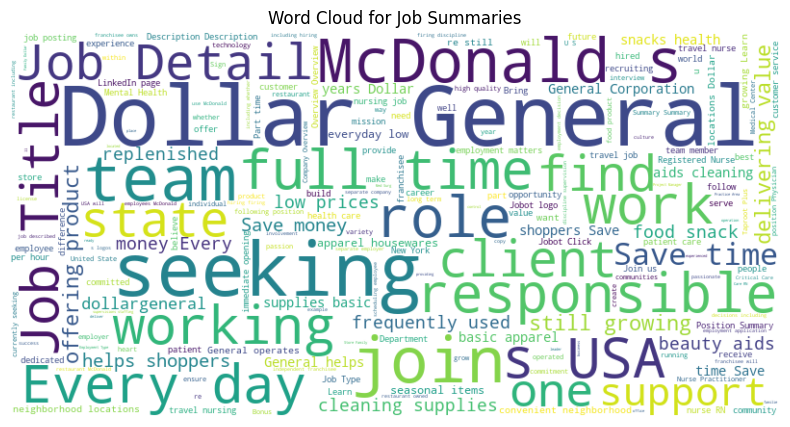

In [87]:
# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_job_summary_text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Job Summaries')
plt.show()

    job_level  avg_num_skills
0  Mid senior       20.828912
1   Associate       20.182474


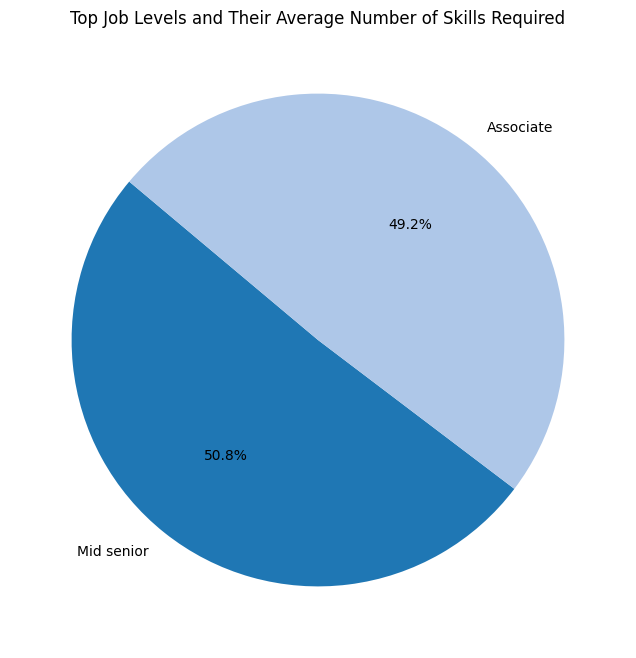

In [88]:
# Calculate the number of skills for each job listing and group by job_level to find the average
top_plot_data = spark.sql("""
    SELECT job_level, AVG(size(split(job_skills, ','))) AS avg_num_skills
    FROM linkedIn_job_postings_2024
    GROUP BY job_level
    ORDER BY avg_num_skills DESC
    LIMIT 10
""").toPandas()  

print(top_plot_data.head())  

labels = top_plot_data['job_level'].tolist()
sizes = top_plot_data['avg_num_skills'].astype(float).tolist()  

# Plot the pie chart
plt.figure(figsize=(12, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.tab20.colors)
plt.title('Top Job Levels and Their Average Number of Skills Required')
plt.show()


In [89]:
job_type_counts = spark.sql("""SELECT job_type, COUNT(*) AS count
                                FROM linkedIn_job_postings_2024
                                GROUP BY job_type
                                ORDER BY count DESC""")

# Convert to Pandas for visualization
job_type_counts_pd = job_type_counts.toPandas()

# Create a bar plot using Plotly
fig = px.bar(job_type_counts_pd, x='job_type', y='count', labels={'count': 'Number of Listings', 'job_type': 'Job Type'}, color='count',  # Color the bars by the count value
    color_continuous_scale='Viridis')

fig.update_layout(
    title={
        'text': 'Job Type Distribution',
        'x': 0.5, 
        'xanchor': 'center',  
        'font': {'size': 20} 
    }
)
fig.update_yaxes(type='log')

fig.show()

In [90]:
# Group by 'job_type' and 'job_level' and count the number of job listings
job_level_type_counts = spark.sql("""SELECT job_type, job_level, COUNT(*) AS count
                                        FROM linkedIn_job_postings_2024
                                        GROUP BY job_type, job_level
                                        ORDER BY job_type, count DESC
                                        """)
# Filter out 'Unknown' job types
job_level_type_counts = job_level_type_counts.filter(F.col('job_type') != 'Unknown')

# Convert the result to a Pandas DataFrame for visualization
job_level_type_counts_pd = job_level_type_counts.toPandas()

# Create a bar plot using Plotly
fig = px.bar(
    job_level_type_counts_pd, 
    x='job_type', 
    y='count', 
    color='job_level', 
    labels={'count': 'Number of Listings', 'job_type': 'Job Type', 'job_level': 'Job Level'}
)
fig.update_layout(
    title={
        'text': 'Job Level Distribution by Job Type',
        'x': 0.5, 
        'xanchor': 'center',  
        'font': {'size': 20} 
    }
)
fig.update_yaxes(type='log')  # Apply log scale to y-axis for better visualization of distribution

# Display the plot
fig.show()


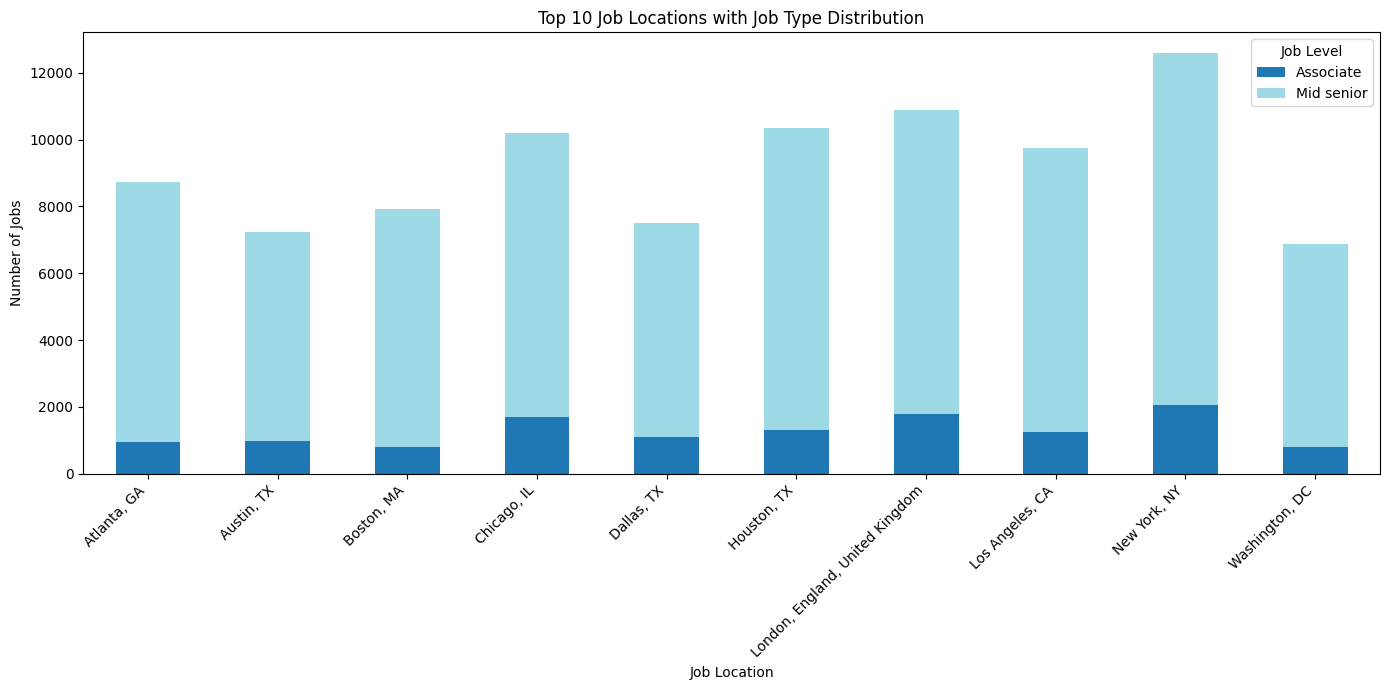

In [91]:
# Group by job location and job type, and count the occurrences
job_location_counts = merged_data.groupBy("job_location", "job_level").count().toPandas()

# Get the top 10 job locations based on the total count
top_10_job_locations = job_location_counts.groupby("job_location")["count"].sum().nlargest(10).index
filtered_counts = job_location_counts[job_location_counts["job_location"].isin(top_10_job_locations)]

# Pivot the DataFrame to get job_level as columns and counts as values
pivot_data = filtered_counts.pivot_table(index="job_location", columns="job_level", values="count", aggfunc="sum").fillna(0)

# Plotting the stacked bar chart
pivot_data.plot(kind='bar', stacked=True, figsize=(14, 7), colormap='tab20')

plt.title("Top 10 Job Locations with Job Type Distribution")
plt.xlabel("Job Location")
plt.ylabel("Number of Jobs")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Job Level")
plt.tight_layout()
plt.show()

### High Competition:
Regions with low competition index values indicate a high number of postings for similar job titles, suggesting a saturated market.
### Low Competition:
Regions with high competition index values indicate diverse job opportunities with less saturation.

  search_country         search_city  total_postings  unique_titles  \
0         Canada             Quesnel              25             25   
1         Canada           Saskatoon              25             25   
2      Australia            Moranbah              20             20   
3         Canada    Laurentian Hills              40             40   
4      Australia          Beechworth              45             45   
5         Canada         Yellowknife              28             28   
6         Canada  Temiskaming Shores              26             26   
7         Canada             Dauphin               5              5   
8      Australia         Maryborough              43             42   
9  United States               Lenox              76             74   

   competition_index  
0           1.000000  
1           1.000000  
2           1.000000  
3           1.000000  
4           1.000000  
5           1.000000  
6           1.000000  
7           1.000000  
8          

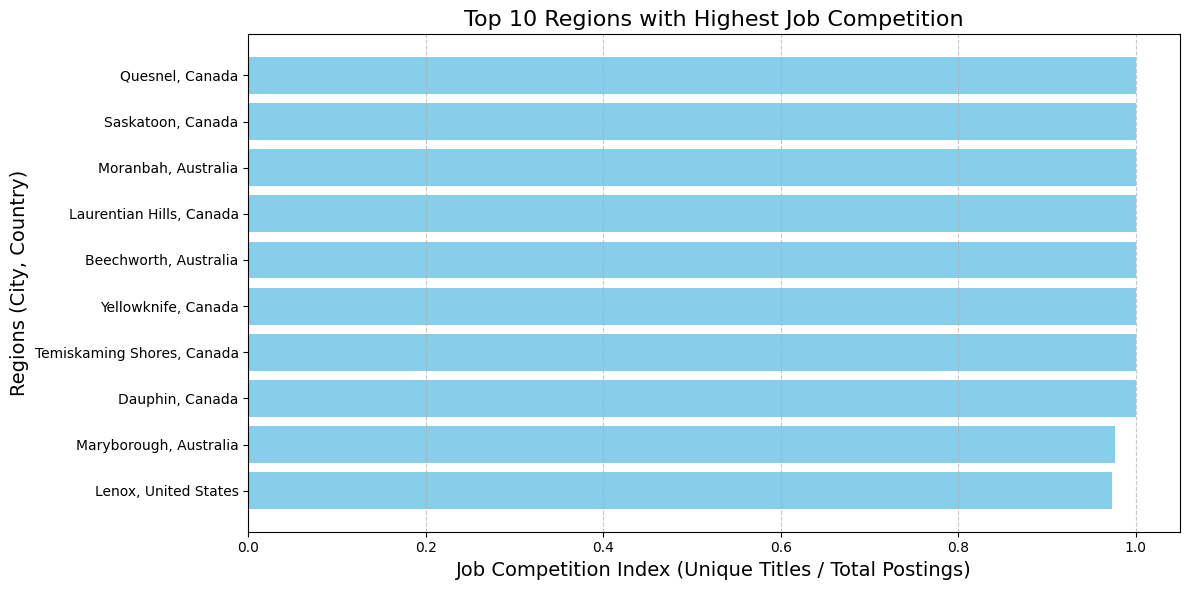

In [92]:
job_competition = (
    merged_data
    .groupBy("search_country", "search_city")  # Group by region (country and city)
    .agg(
        F.count("job_title").alias("total_postings"),  # Total job postings
        F.countDistinct("job_title").alias("unique_titles")  # Unique job titles
    )
    .withColumn("competition_index", F.col("unique_titles") / F.col("total_postings"))  # Compute the Job Competition Index
    .orderBy("competition_index", ascending=False)  # Sort by competition index (higher is more competition)
)

# Step 2: Convert to Pandas for better readability (if dataset is small)
job_competition_pd = job_competition.toPandas()

# Step 3: Display the top 10 regions with the highest competition
print(job_competition_pd.head(10))

# Step 4: Visualize Job Competition Index for the top 10 regions
top_regions = job_competition_pd.head(10)
plt.figure(figsize=(12, 6))
plt.barh(top_regions["search_city"] + ", " + top_regions["search_country"], top_regions["competition_index"], color="skyblue")
plt.xlabel("Job Competition Index (Unique Titles / Total Postings)", fontsize=14)
plt.ylabel("Regions (City, Country)", fontsize=14)
plt.title("Top 10 Regions with Highest Job Competition", fontsize=16)
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

+----------+--------------------+------------+
|first_seen| last_processed_time|time_to_fill|
+----------+--------------------+------------+
|2024-01-17|2024-01-21 02:21:...|           4|
|2024-01-13|2024-01-19 04:45:...|           6|
|2024-01-13|2024-01-19 04:45:...|           6|
|2024-01-14|2024-01-19 14:46:...|           5|
|2024-01-12|2024-01-19 04:45:...|           7|
|2024-01-14|2024-01-19 07:50:...|           5|
|2024-01-14|2024-01-20 18:47:...|           6|
|2024-01-12|2024-01-19 04:45:...|           7|
|2024-01-12|2024-01-19 04:45:...|           7|
|2024-01-12|2024-01-19 04:45:...|           7|
|2024-01-12|2024-01-19 04:45:...|           7|
|2024-01-12|2024-01-19 04:45:...|           7|
|2024-01-12|2024-01-19 04:45:...|           7|
|2024-01-12|2024-01-19 04:45:...|           7|
|2024-01-12|2024-01-19 04:45:...|           7|
|2024-01-12|2024-01-19 04:45:...|           7|
|2024-01-12|2024-01-19 04:45:...|           7|
|2024-01-12|2024-01-19 04:45:...|           7|
|2024-01-13|2

/Users/nirvikarajendra/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



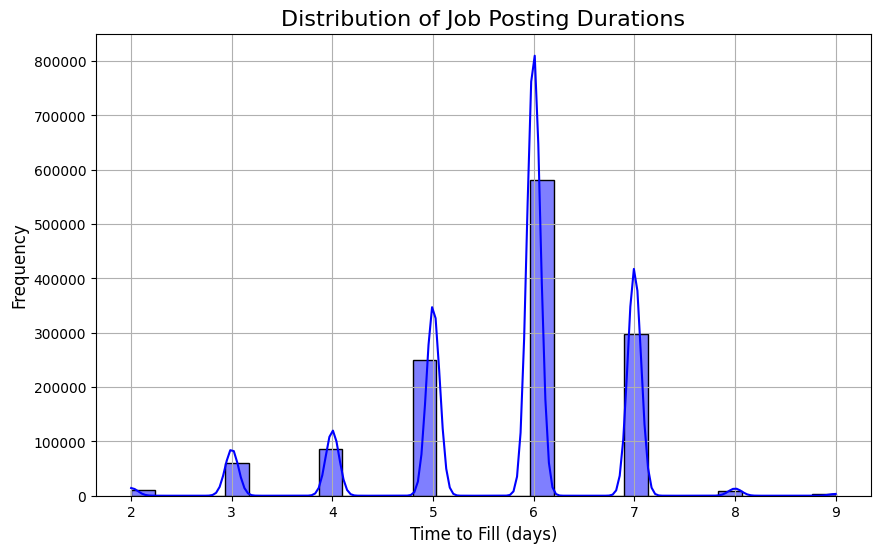

In [93]:
# Calculate the duration between the first posted and last processed time
merged_data = merged_data.withColumn("time_to_fill", datediff(col("last_processed_time"), col("first_seen")))

merged_data.select("first_seen", "last_processed_time", "time_to_fill").show()

pandas_df = merged_data.select("time_to_fill").toPandas()

# Plot a histogram
plt.figure(figsize=(10, 6))
sns.histplot(pandas_df["time_to_fill"], bins=30, kde=True, color='blue')
plt.title("Distribution of Job Posting Durations", fontsize=16)
plt.xlabel("Time to Fill (days)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid()
plt.show()

## Visualizing Job Locations

In [94]:
#Define a Hive SQL query to extract job location details
get_loc_details = """SELECT *,
                        SPLIT(job_location, ',')[0] as Job_city,
                        SPLIT(job_location, ',')[1] as Job_state,
                        SPLIT(job_location, ',')[2] as Job_country
                    from linkedIn_job_postings_2024 """


In [95]:
job_location_df = spark.sql(get_loc_details)
job_location_df.write.mode("overwrite").saveAsTable("net_jobs")


In [96]:
job_location_df = job_location_df.dropna(subset=['Job_country'])
job_location_df = job_location_df.dropna(subset=['Job_city'])

In [97]:
top_titles = spark.sql("""
                        SELECT job_title, COUNT(*) AS count
                        FROM net_jobs
                        WHERE LOWER(Job_country) LIKE '%india%'
                          AND LOWER(job_title) NOT LIKE '%apply now%'
                        GROUP BY job_title
                        ORDER BY count DESC
                        LIMIT 10
                    """)

Text(0, 0.5, 'Job Title')

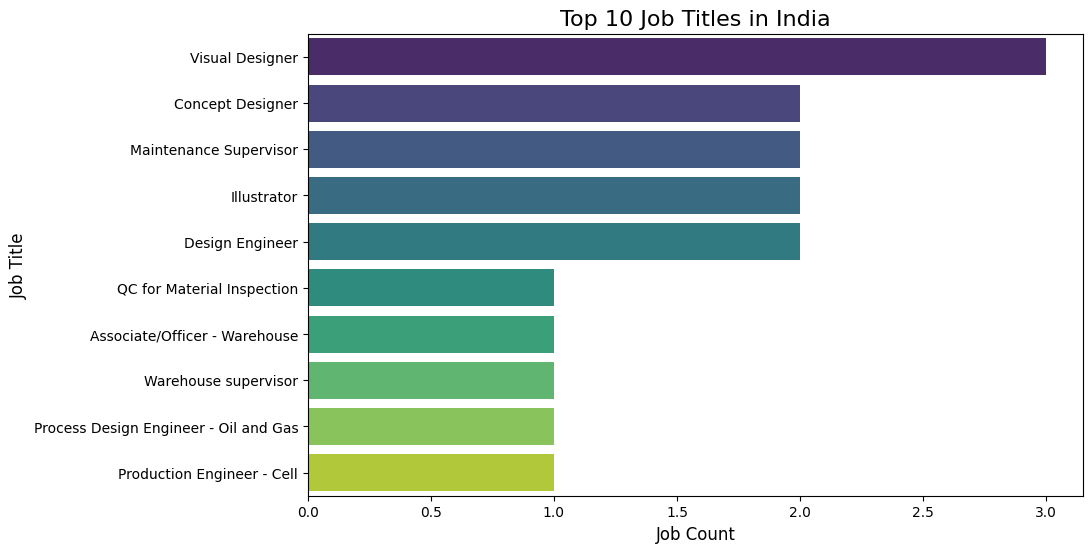

In [98]:
# Plotting top 10 job titles in India
top_titles_pd = top_titles.toPandas()
plt.figure(figsize=(10, 6))

sns.barplot(x="count", y="job_title", data=top_titles_pd, palette="viridis")

plt.title('Top 10 Job Titles in India', fontsize=16)
plt.xlabel('Job Count', fontsize=12)
plt.ylabel('Job Title', fontsize=12)

In [99]:
top_skills_uk = spark.sql("""
    SELECT job_skills, COUNT(*) AS count
    FROM net_jobs
    WHERE LOWER(Job_country) LIKE '%united kingdom%'
      AND job_skills NOT LIKE '%Unknown%'
      AND LENGTH(job_skills) < 100
      AND job_skills NOT LIKE '%experience%'
      AND job_skills NOT LIKE '%year%'
      AND job_skills NOT LIKE '%registered%'
    GROUP BY job_skills
    ORDER BY count DESC
    LIMIT 10
""")


In [100]:
top_skills_uk.show(truncate = False)

+-----------------------------------------------------------------------------------------+-----+
|job_skills                                                                               |count|
+-----------------------------------------------------------------------------------------+-----+
|Nursing, UK Registered Nurse, Personcentered care                                        |11   |
|Mental Health Nursing, NMC Registration                                                  |10   |
|Nursing                                                                                  |10   |
|Architect                                                                                |9    |
|Nursing, Elderly Care, NMC PIN                                                           |8    |
|UK Registered Nurse, Personcentered care                                                 |6    |
|Dentistry                                                                                |6    |
|Nursing, UK Registe

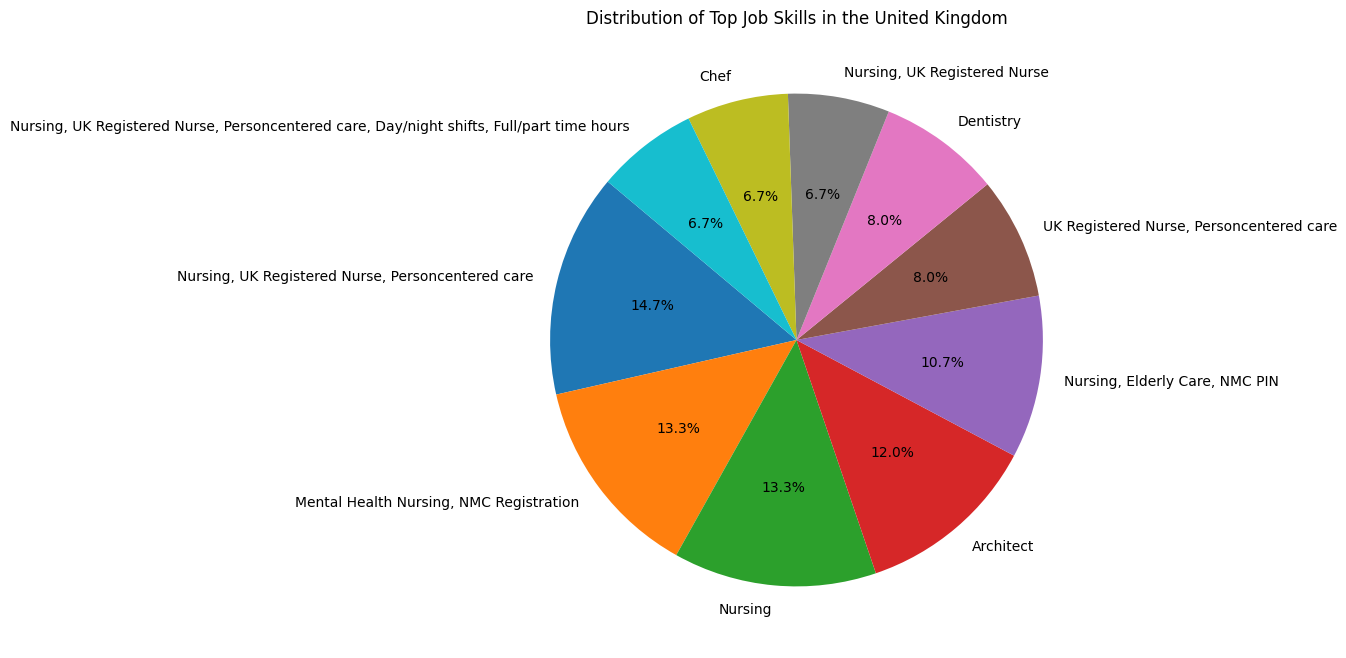

In [101]:
top_skills_uk_pd = top_skills_uk.toPandas()
plt.figure(figsize=(8, 8))

# Create a pie chart to visualize the distribution of top job skills in the United Kingdom
plt.pie(top_skills_uk_pd['count'], labels=top_skills_uk_pd['job_skills'], autopct='%1.1f%%', startangle=140)

# Set the title
plt.title('Distribution of Top Job Skills in the United Kingdom')

# Show the plot
plt.show()

In [102]:
count_query = """
                SELECT COUNT(DISTINCT Job_city) AS city_count
                FROM net_jobs
                WHERE Job_city IS NOT NULL
                """
count_cities = spark.sql(count_query)
count_cities.show()

+----------+
|city_count|
+----------+
|     21046|
+----------+



In [103]:
df_city_companies = spark.sql("""
                                SELECT Job_city, COUNT(DISTINCT company) AS company_count
                                FROM net_jobs
                                WHERE Job_city IS NOT NULL
                                GROUP BY Job_city
                                ORDER BY company_count DESC
                                LIMIT 10;
                                """)


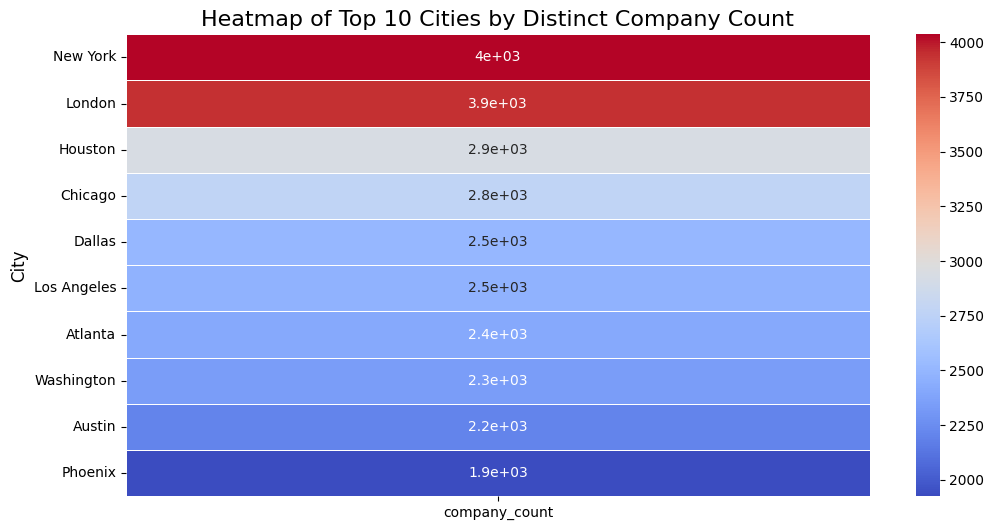

In [104]:
# Convert the Spark DataFrame to Pandas DataFrame
df_city_companies_pd = df_city_companies.toPandas()

# Reshape the data to make it suitable for plotting
heatmap_data = df_city_companies_pd.set_index('Job_city')

# Plotting the heatmap
plt.figure(figsize=(12, 6))
heatmap = sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', cbar=True, linewidths=0.5)

# Set labels and title
plt.title('Heatmap of Top 10 Cities by Distinct Company Count', fontsize=16)
plt.ylabel('City', fontsize=12)

# Display the plot
plt.show()


In [105]:

# Function to get latitude and longitude
def get_lat_lon(city_name):
    try:
        location = geolocator.geocode(city_name)
        if location:
            return location.latitude, location.longitude
        else:
            return None, None
    except Exception as e:
        print(f"Error for {city_name}: {e}")
        return None, None

In [106]:
job_location_df.select('Job_country').filter(F.col('Job_country').isNotNull()).distinct().show()

+--------------------+
|         Job_country|
+--------------------+
|           Australia|
| Newfoundland and...|
|              Canada|
| United Arab Emir...|
|             Germany|
|               Spain|
|         Philippines|
|            Malaysia|
|               India|
|           Argentina|
|               Italy|
|              Brazil|
|               China|
|              Greece|
|            Cameroon|
|      United Kingdom|
|              Mexico|
|              France|
|             Belgium|
|               Egypt|
+--------------------+
only showing top 20 rows



In [107]:

# Retrieve the distinct countries where job listings are available.
distinct_countries = job_location_df.select('Job_city').filter(F.col('Job_city').isNotNull()).distinct().limit(100)

# Convert the top countires DataFrame to a Pandas DataFrame for geocoding
distinct_countries_pd = distinct_countries.toPandas()

# Initialize geocoder
geolocator = Nominatim(user_agent="geoapi",timeout=40)

# Create a map centered at a default location
m = folium.Map(location=[0, 0], zoom_start=2)

# Add markers for the top 100 highest searched cities
for country in distinct_countries_pd['Job_city']:
    latitude, longitude = get_lat_lon(country)
    if latitude and longitude:
        folium.Marker(
            location=[latitude, longitude],
            popup=country,
            icon=folium.Icon(color='darkblue')
        ).add_to(m)

display(m)

In [108]:
# Get the top 20 highest searched cities
top_cities_df = merged_data.filter(F.col("search_city").isNotNull() & (F.col("search_city") != "Unknown"))

# Get the top 20 highest searched cities
top_cities_df = top_cities_df.groupBy("search_city").count().orderBy(F.desc("count")).limit(100)

# Convert the top cities DataFrame to a Pandas DataFrame for geocoding
top_cities_pd = top_cities_df.toPandas()

# Initialize geocoder
geolocator = Nominatim(user_agent="geoapi",timeout=10)

# Create a map centered at a default location
m = folium.Map(location=[0, 0], zoom_start=2)

# Add markers for the top 100 highest searched cities
for city in top_cities_pd['search_city']:
    latitude, longitude = get_lat_lon(city)
    if latitude and longitude:
        folium.Marker(
            location=[latitude, longitude],
            popup=city,
            icon=folium.Icon(color='blue')
        ).add_to(m)

display(m)


In [109]:
# Get the top 100 job locations by country based on job counts
top_locations_df = (
    job_location_df.groupBy("Job_country")
    .count()  
    .orderBy(desc("count")) 
    .limit(100) 
)

In [110]:
top_locations_df.show()

+--------------------+------+
|         Job_country| count|
+--------------------+------+
|      United Kingdom|105770|
|              Canada| 51412|
|           Australia| 26719|
|              Mexico|  1543|
|               India|    62|
|              France|    34|
|            Malaysia|    27|
|               China|    21|
| United Arab Emir...|    16|
|               Italy|    13|
| Newfoundland and...|    12|
|        Saudi Arabia|    12|
|         Nova Scotia|    10|
|             Germany|     9|
|         Netherlands|     9|
|         Philippines|     7|
|              Brazil|     6|
|               Spain|     5|
|           Argentina|     5|
|              Greece|     5|
+--------------------+------+
only showing top 20 rows



In [111]:
distinct_countries_pd = top_locations_df.select("Job_country").distinct().toPandas()

# Add latitude and longitude for each country
lat_lon_data = []
for country in distinct_countries_pd['Job_country']:
    latitude, longitude = get_lat_lon(country)
    if latitude and longitude:
        lat_lon_data.append({"Job_country": country, "latitude": latitude, "longitude": longitude})

# Convert to pandas DataFrame
lat_lon_df = pd.DataFrame(lat_lon_data)

# Merge with filtered DataFrame to get counts
filtered_pd = top_locations_df.toPandas()
viz_data = (
    filtered_pd.merge(lat_lon_df, on="Job_country")
    .groupby(["latitude", "longitude", "Job_country"])
    .size()
    .reset_index(name="count")
)

In [116]:
fig = px.scatter_geo(
    viz_data,
    lat="latitude",
    lon="longitude",
    size="count",
    color="Job_country",
    hover_name="Job_country",
    title="Global Heatmap of Job Locations",
    projection="orthographic"
)

fig.show()


In [113]:
fig = px.scatter_3d(
    viz_data,
    x="longitude",
    y="latitude",
    z="count",
    color="Job_country",
    hover_name="Job_country",
    title="3D Visualization of Job Locations"
)
fig.show()

## Job Dashboard: Search, Visualize, and Recommend Opportunities Based on Skills and Location

In [114]:

# Helper function to clear and display outputs
def clear_and_display(output, content):
    output.clear_output()
    with output:
        content()

# Widgets for Region Filtering
region_dropdown = widgets.Dropdown(
    options=['All'] + job_location_df.select("Job_country").distinct().rdd.flatMap(lambda x: x).collect(),
    value='All',
    description='Country:',
    layout=widgets.Layout(width='50%')
)

city_dropdown = widgets.Dropdown(
    options=['All'] + job_location_df.select("Job_city").distinct().rdd.flatMap(lambda x: x).collect(),
    value='All',
    description='City:',
    layout=widgets.Layout(width='50%')
)

def update_cities(*args):
    if region_dropdown.value == 'All':
        city_dropdown.options = ['All']
    else:
        cities = job_location_df.filter(col("Job_country") == region_dropdown.value)\
            .select("Job_city").distinct().rdd.flatMap(lambda x: x).collect()
        city_dropdown.options = ['All'] + cities

region_dropdown.observe(update_cities, 'value')


# Widgets for "Search Jobs by Skills"
skill_input = widgets.Text(
    value='',
    placeholder='Enter skills (e.g., Python, Machine Learning)',
    description='Skills:',
    layout=widgets.Layout(width='50%')
)

submit_button = widgets.Button(
    description='Search',
    button_style='success',
    icon='search'
)

search_output = widgets.Output()

# Search Functionality
def search_jobs_by_skills(b):
    def content():
        skills = [skill.strip().lower() for skill in skill_input.value.split(",") if skill.strip()]
        if not skills:
            print("Please enter at least one skill.")
            return
        
        # Filter jobs by skills (case-insensitive)
        condition = " OR ".join([f"array_contains(split(lower(job_skills), ', '), '{skill}')" for skill in skills])
        filtered_jobs = job_location_df.withColumn("job_skills", lower(col("job_skills"))).filter(expr(condition)).toPandas()
        
        if not filtered_jobs.empty:
            print(f"Jobs matching the skills: {', '.join(skills)}")
            for link in filtered_jobs["job_link"]:
                print(f"- {link}")
        else:
            print("No matching jobs found.")
    clear_and_display(search_output, content)

submit_button.on_click(search_jobs_by_skills)

# Widgets for "Visualize Jobs by Skill"
visualize_skill_input = widgets.Text(
    value='',
    placeholder='Enter a skill (e.g., Python)',
    description='Skill:',
    layout=widgets.Layout(width='50%')
)

visualize_button = widgets.Button(
    description='Visualize',
    button_style='primary',
    icon='bar-chart'
)

visualize_output = widgets.Output()

def visualize_jobs_by_skill(b):
    def content():
        skill = visualize_skill_input.value.strip().lower()
        if not skill:
            print("Please enter a skill.")
            return
        
        # Filter jobs by skill (case-insensitive)
        filtered_jobs = job_location_df.withColumn("job_skills", lower(col("job_skills"))).filter(expr(f"array_contains(split(job_skills, ', '), '{skill}')"))
        job_counts = filtered_jobs.groupBy("Job_country").count().toPandas()
        
        if not job_counts.empty:
            job_counts = job_counts.sort_values(by="count", ascending=False)
            plt.figure(figsize=(10, 6))
            plt.bar(job_counts["Job_country"], job_counts["count"], color='skyblue')
            plt.title(f"Job Counts by Country Requiring Skill: {skill}", fontsize=16)
            plt.xlabel("Country", fontsize=14)
            plt.ylabel("Job Count", fontsize=14)
            plt.xticks(rotation=45)
            plt.grid(axis="y", linestyle="--", alpha=0.7)
            plt.tight_layout()
            plt.show()
        else:
            print(f"No jobs found requiring the skill: {skill}")
    clear_and_display(visualize_output, content)

visualize_button.on_click(visualize_jobs_by_skill)

# Widgets for "Recommend Jobs"
recommend_skills_input = widgets.Text(
    value='',
    placeholder='Enter skills (e.g., Python, Machine Learning)',
    description='Skills:',
    layout=widgets.Layout(width='50%')
)

job_type_dropdown = widgets.Dropdown(
    options=['All', 'Remote', 'Onsite', 'Hybrid'],
    value='All',
    description='Job Type:',
    layout=widgets.Layout(width='50%')
)

recommend_button = widgets.Button(
    description='Recommend',
    button_style='success',
    icon='search'
)

recommend_output = widgets.Output()

def recommend_jobs(b):
    def content():
        skills = [skill.strip().lower() for skill in recommend_skills_input.value.split(",") if skill.strip()]
        job_type = job_type_dropdown.value
        
        if not skills:
            print("Please enter at least one skill.")
            return
        
        # Filter jobs by skills and type (case-insensitive)
        skill_condition = " OR ".join([f"array_contains(split(lower(job_skills), ', '), '{skill}')" for skill in skills])
        filtered_jobs = job_location_df.withColumn("job_skills", lower(col("job_skills"))).filter(expr(skill_condition))
        if job_type != 'All':
            filtered_jobs = filtered_jobs.filter(col("job_type") == job_type)
        
        results = filtered_jobs.select("job_link", "job_title", "company").limit(10).toPandas()
        if not results.empty:
            print("Recommended Jobs:")
            for _, row in results.iterrows():
                print(f"- {row['job_title']} at {row['company']} [Job Link: {row['job_link']}]")
        else:
            print("No matching jobs found.")
    clear_and_display(recommend_output, content)

recommend_button.on_click(recommend_jobs)

# Organizing into Tabs
tabs = widgets.Tab()



search_tab = widgets.VBox([widgets.HTML("<h2>Search Jobs by Skills</h2>"), skill_input, submit_button, search_output])
visualize_tab = widgets.VBox([widgets.HTML("<h2>Visualize Jobs by Skill</h2>"), visualize_skill_input, visualize_button, visualize_output])
recommend_tab = widgets.VBox([widgets.HTML("<h2>Recommend Jobs</h2>"), recommend_skills_input, job_type_dropdown, recommend_button, recommend_output])

tabs.children = [search_tab, visualize_tab, recommend_tab]
tabs.set_title(0, "Search Jobs")
tabs.set_title(1, "Visualize Jobs")
tabs.set_title(2, "Recommend Jobs")

# Display the Dashboard
display(tabs)

In [115]:
spark.stop

<bound method SparkSession.stop of <pyspark.sql.session.SparkSession object at 0x1534fb1d0>>


# Conclusion

## Summary of Findings
The project successfully analyzed LinkedIn job data to uncover valuable trends in job requirements and locations. Insights include:
1. The most in-demand job skills and industries.
2. Trends in job postings across different regions.

## Future Directions
Further exploration can focus on:
1. Automating real-time job trend analysis using streaming data.
2. Incorporating additional datasets to provide richer context, such as salary data or company reviews.
3. Developing predictive models to forecast job demand in various sectors.

---
    